In [1]:
#IMPORTANDO LIBRERIAS NECESARIAS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('hr_data_cleaned.csv', index_col=0)
df.head(1)

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,employeenumber,environmentsatisfaction,gender,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome_$,monthlyrate_$,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,datebirth,salary,remotework,generation
0,53,No,NaN,2015.722222,research & development,6,3,NaN,1,1,Male,3,5,research director,3,NaN,16280.83,42330.17,7,No,13,3.0,3,Full Time,0,5,3.0,20,15.0,15,15,1972,195370.0,True,Gen X


# Context

## Salary

                mean  median  count
attrition                          
No         15.193358    14.0   1355
Yes        15.019305    14.0    259


/var/folders/fw/63lcqvrj3gj5_78zkmp2ql8r0000gp/T/ipykernel_20243/778241221.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="attrition", y="percentsalaryhike", palette="Set2")


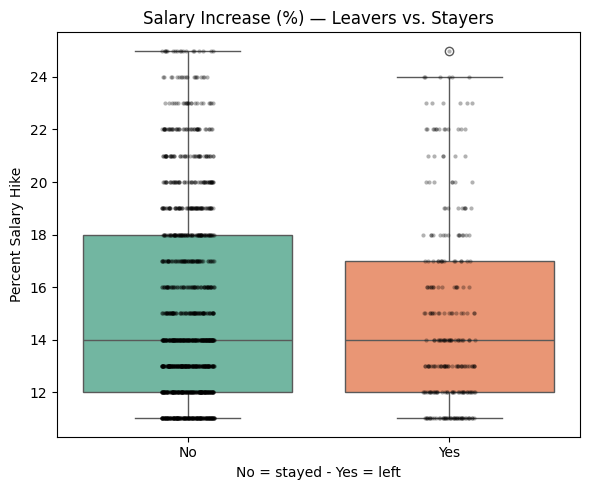

In [48]:
# Summary statistics
hike_summary = (
    df.groupby("attrition")["percentsalaryhike"]
      .agg(['mean','median','count'])
)
print(hike_summary)

# Boxplot comparison
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x="attrition", y="percentsalaryhike", palette="Set2")
sns.stripplot(data=df, x="attrition", y="percentsalaryhike",
              color="black", alpha=0.3, size=3)

plt.title("Salary Increase (%) — Leavers vs. Stayers")
plt.xlabel("No = stayed - Yes = left")
plt.ylabel("Percent Salary Hike")
plt.tight_layout()
plt.show()


Roles with potential inequity:
                      jobrole             lower_ed            higher_ed  \
0   healthcare representative    Primary Education  Secondary Education   
1   healthcare representative    Primary Education  Technical Education   
2   healthcare representative    Primary Education    University Degree   
3   healthcare representative    Primary Education  Postgraduate Degree   
4   healthcare representative  Technical Education    University Degree   
5   healthcare representative  Technical Education  Postgraduate Degree   
6   healthcare representative    University Degree  Postgraduate Degree   
7                     manager    Primary Education  Technical Education   
8                     manager    Primary Education  Postgraduate Degree   
9                     manager  Secondary Education  Technical Education   
10                    manager  Secondary Education    University Degree   
11                    manager  Secondary Education  Postgraduate Degr

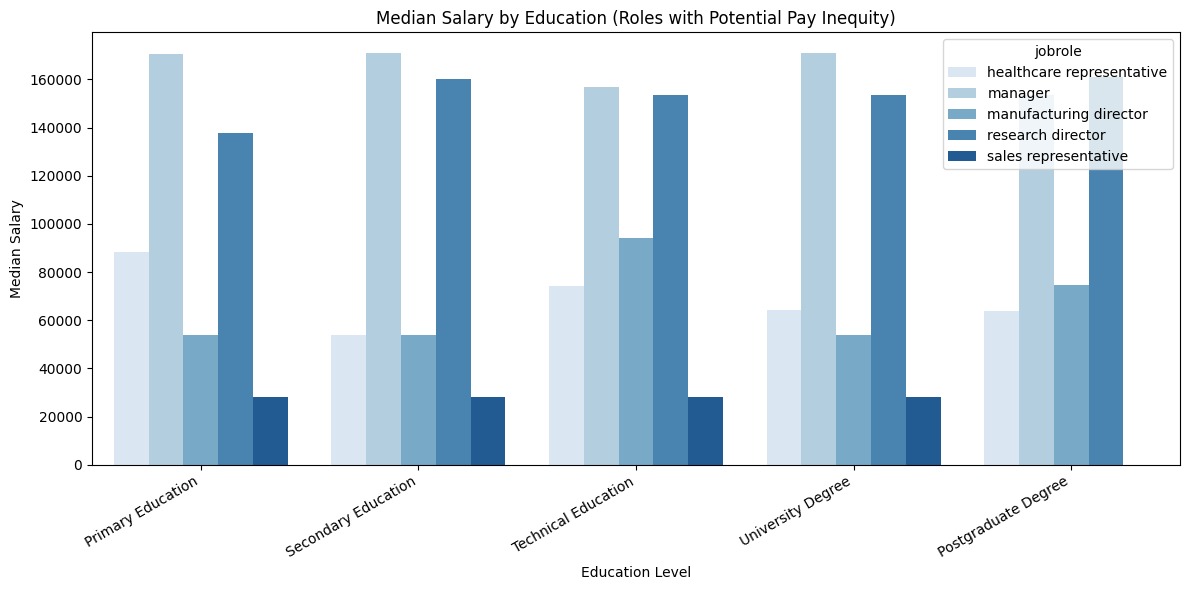

In [58]:
# Choose salary column depending on your dataset
salary_col = 'salary' if 'salary' in df.columns else 'monthlyincome_$'

# Map education codes to labels (if not already mapped)
if 'education_label' not in df.columns:
    edu_map = {
        1: 'Primary Education',
        2: 'Secondary Education',
        3: 'Technical Education',
        4: 'University Degree',
        5: 'Postgraduate Degree'
    }
    df['education_label'] = df['education'].map(edu_map).fillna(df['education'].astype(str))

#  Median salary by job role and education
med_by_role_edu = (
    df.groupby(['jobrole', 'education_label'])[salary_col]
      .median()
      .reset_index()
      .rename(columns={salary_col: 'median_salary'})
)

# Detect inequities (lower education > higher education)
edu_order = [
    'Primary Education',
    'Secondary Education',
    'Technical Education',
    'University Degree',
    'Postgraduate Degree'
]

inequities = []

for role in med_by_role_edu['jobrole'].unique():
    role_data = med_by_role_edu[med_by_role_edu['jobrole'] == role]

    for i, low in enumerate(edu_order):
        for high in edu_order[i+1:]:
            low_val = role_data.loc[role_data['education_label'] == low, 'median_salary']
            high_val = role_data.loc[role_data['education_label'] == high, 'median_salary']

            if not low_val.empty and not high_val.empty:
                low_m = float(low_val.iloc[0])
                high_m = float(high_val.iloc[0])
                if low_m > high_m:
                    inequities.append({
                        'jobrole': role,
                        'lower_ed': low,
                        'higher_ed': high,
                        'median_low': low_m,
                        'median_high': high_m,
                        'diff': low_m - high_m
                    })

# Build DataFrame with column names
inequities_df = pd.DataFrame(inequities, columns=[
    'jobrole', 'lower_ed', 'higher_ed', 'median_low', 'median_high', 'diff'
])

print("Roles with potential inequity:")
print(inequities_df if not inequities_df.empty else "No roles flagged with current data.")

# Plot only if there are inequities
if not inequities_df.empty:
    roles_with_issues = sorted(inequities_df['jobrole'].unique().tolist())
    subset = med_by_role_edu[med_by_role_edu['jobrole'].isin(roles_with_issues)].copy()

    # Keep education order on x-axis (only present levels)
    present_order = [lvl for lvl in edu_order if lvl in subset['education_label'].unique()]

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=subset,
        x='education_label',
        y='median_salary',
        hue='jobrole',
        order=present_order,
        palette='Blues'
    )

    plt.title('Median Salary by Education (Roles with Potential Pay Inequity)')
    plt.xlabel('Education Level')
    plt.ylabel('Median Salary')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()
else:
    # Nothing to plot
    pass


# Generation

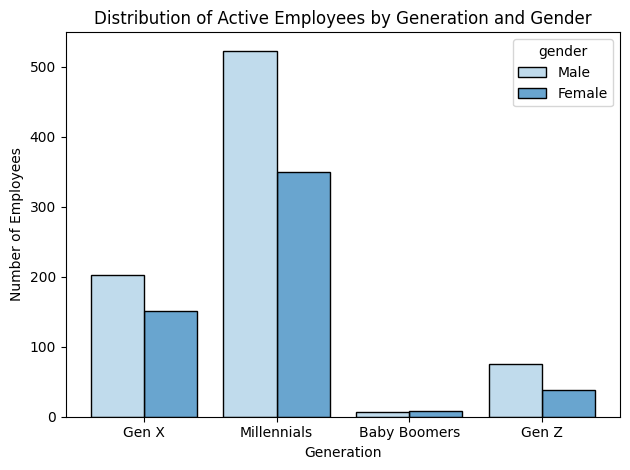

In [26]:
# Filtrar solo empleados que permanecen en la empresa
# “Dentro dos Millennials, cual a % quedo?”
# “Dentro da Gen Z, cual % quedo?”

df_attrition_no = df[df['attrition'] == 'No']

# Histograma con hue por género
sns.histplot(data=df_attrition_no,
             x='generation',
             hue='gender',
             multiple='dodge',
             shrink=0.8,palette='Blues')

plt.title('Distribution of Active Employees by Generation and Gender')
plt.xlabel('Generation')
plt.ylabel('Number of Employees')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



### Aunque la mayoría de los empleados actuales de la empresa pertenecen a la generación Millennial, los datos muestran que la Generación Z es la que más ha abandonado la organización en términos proporcionales.

In [33]:
# Cuántos empleados dejaron la empresa ("Yes") por generación
# DataFrame con proporciones de attrition = Yes por generación
attrition_rate = df[df['attrition'] == 'Yes'].groupby('generation').size() / df.groupby('generation').size()
round(attrition_rate * 100, 2)

generation
Baby Boomers      NaN
Gen X           12.38
Gen Z           35.43
Millennials     14.41
dtype: float64

/var/folders/fw/63lcqvrj3gj5_78zkmp2ql8r0000gp/T/ipykernel_20243/1147992613.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attrition_rate.index, y=attrition_rate.values, palette='Blues')


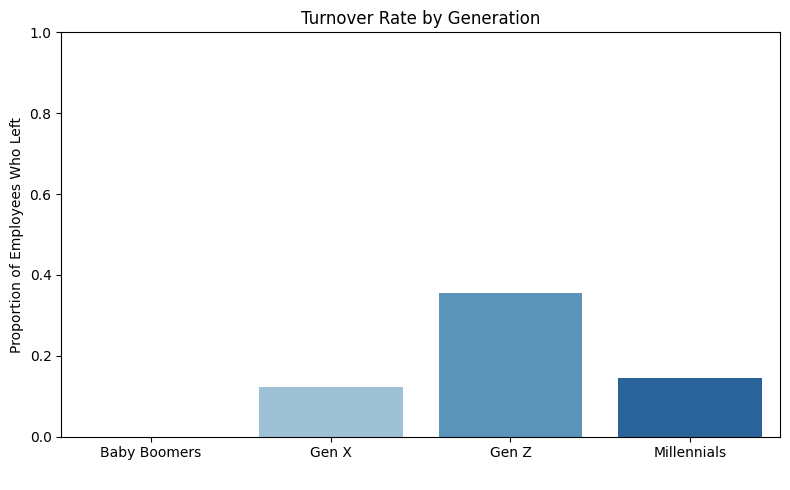

In [38]:
# Graficar
plt.figure(figsize=(8,5))
sns.barplot(x=attrition_rate.index, y=attrition_rate.values, palette='Blues')
plt.ylabel("Proportion of Employees Who Left")
plt.xlabel(" ")
plt.title("Turnover Rate by Generation")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

### This result can be explained by considering the general characteristics of each generation

#### Baby Boomers (born approx. 1946–1964)
Loyal and committed to long-term employment.  
They value stability and structure.  
Their presence in the company is minimal or nonexistent, and they show virtually no turnover cases.  

#### Generation X (1965–1980)
Value autonomy, work–life balance, and a practical approach.  
Moderate turnover; they tend to stay if they find flexibility and recognition.  

#### Millennials (1981–1996)
The most numerous generation within the company.  
They value purpose, continuous learning, and a collaborative environment.  
Their turnover rate is low compared to their total volume, indicating effective integration.  

#### Generation Z (1997 onwards)
Younger, digital natives with high expectations for career mobility.  
They seek rapid development, flexibility, and a clear sense of purpose.  
Despite being less numerous than Millennials, they show the highest turnover rate, which suggests potential challenges in adaptation and retention for the company.  

⚠️ Over time, they will become the most representative generation.  

In [7]:
# No hay Gen Z en Research Director y Manager
tabela = pd.crosstab(df['jobrole'], df['generation']).reset_index()
tabela


generation,jobrole,Baby Boomers,Gen X,Gen Z,Millennials
0,healthcare representative,1,51,3,94
1,human resources,1,12,8,36
2,laboratory technician,1,45,52,180
3,manager,3,71,0,37
4,manufacturing director,2,39,8,109
5,research director,0,51,0,37
6,research scientist,1,50,47,216
7,sales executive,6,76,27,260
8,sales representative,0,9,30,51


# Genero

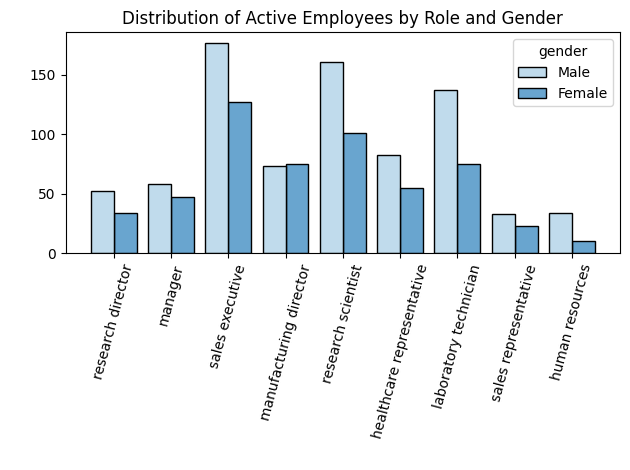

In [20]:

df_attrition_no = df[df['attrition'] == 'No']

# Histograma con hue por género
sns.histplot(data=df_attrition_no,
             x= 'jobrole',
             hue='gender',
             multiple='dodge',
             shrink=0.8,palette="Blues")

plt.title('Distribution of Active Employees by Role and Gender')
plt.xlabel(' ')
plt.ylabel(' ')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


In [9]:
# Oportunidad de iguald de genero (exepcion manufacturing director)
tabela_1 = pd.crosstab(df['jobrole'], df['gender']).reset_index()
tabela_1

gender,jobrole,Female,Male
0,healthcare representative,62,87
1,human resources,17,40
2,laboratory technician,92,186
3,manager,49,62
4,manufacturing director,79,79
5,research director,35,53
6,research scientist,120,194
7,sales executive,149,220
8,sales representative,40,50


# Educacation

La mayoría de los empleados posee estudios universitarios (nivel 3) o de posgrado (nivel 4), lo cual es coherente con el perfil de una empresa tecnológica especializada en inteligencia artificial y ciencia de datos como ABC Corporation.

Dado que una parte considerable del personal se encuentra en los niveles 3 y 4, podría ser estratégico fomentar programas de formación continua, como becas para másteres o doctorados, que refuercen la retención y el desarrollo del talento interno.

/var/folders/fw/63lcqvrj3gj5_78zkmp2ql8r0000gp/T/ipykernel_20243/1628251101.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=educ_counts.index, y=educ_counts.values, palette='Blues')


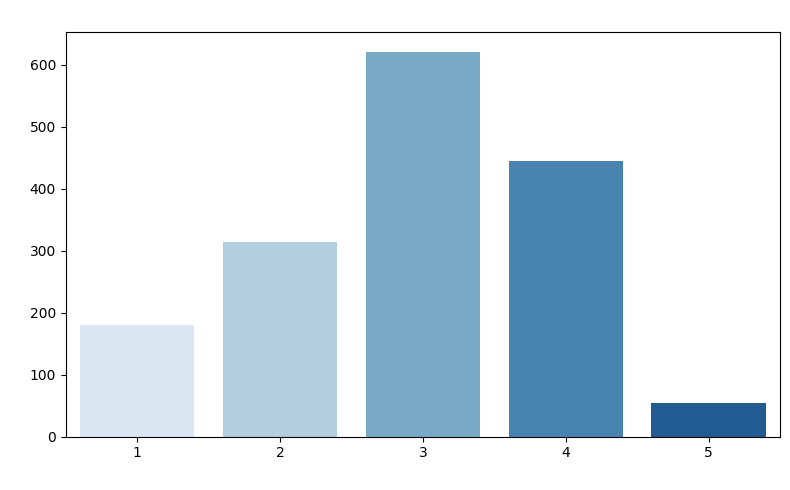

In [ ]:
educ_counts = df['education'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=educ_counts.index, y=educ_counts.values, palette='viridis')
plt.xlabel(' ')
plt.ylabel('Quantidade de Funcionários')
plt.title('Distribuicion dos Niveles Educacionales')
plt.tight_layout()
plt.show()

## Departamiento 

In [11]:
df[df['department'] == 'human resources']['environmentsatisfaction'].unique()

array([1, 3, 2, 4])

/var/folders/fw/63lcqvrj3gj5_78zkmp2ql8r0000gp/T/ipykernel_94779/1749605686.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='department', y='jobsatisfaction', palette='viridis')


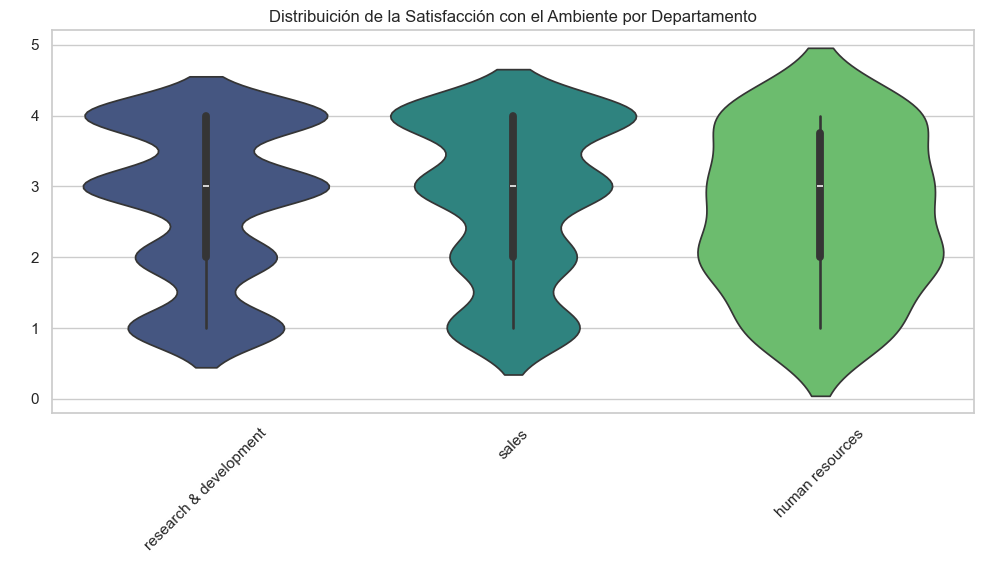

In [28]:
# Satisfação no ambiente de trabalho por departamento
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='department', y='jobsatisfaction', palette='viridis')
plt.xticks(rotation=45)
plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Distribuición de la Satisfacción con el Ambiente por Departamento')
plt.tight_layout()
plt.show()

In [13]:
df[df['department'] == 'human resources']['jobsatisfaction'].unique()


array([2, 4, 1, 3])

/var/folders/fw/63lcqvrj3gj5_78zkmp2ql8r0000gp/T/ipykernel_20243/3980670101.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_merged, x='department', y='satisfacao_media', palette='Blues')


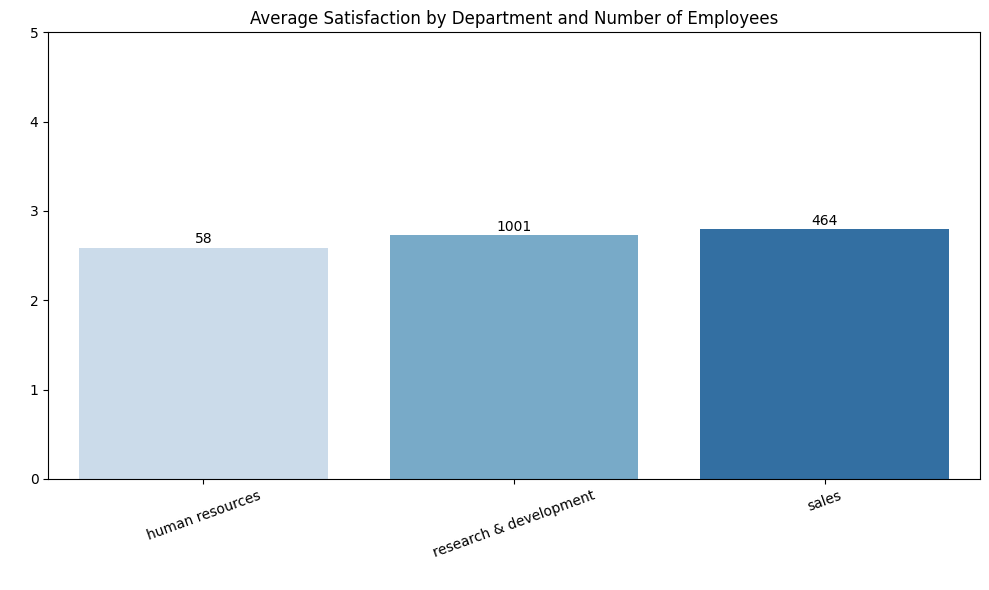

In [64]:
# Calcular média de satisfação e número de funcionários por departamento
satisfacao_media = df.groupby('department')['jobsatisfaction'].mean()
tamanho_departamento = df['department'].value_counts()

# Criar DataFrame combinado
df_merged = pd.DataFrame({
    'satisfacao_media': satisfacao_media,
    'num_funcionarios': tamanho_departamento
}).reset_index()

# Gráfico de barras com anotação do volume
plt.figure(figsize=(10, 6))
sns.barplot(data=df_merged, x='department', y='satisfacao_media', palette='Blues')

# Adicionar número de funcionários acima das barras
for index, row in df_merged.iterrows():
    plt.text(index, row.satisfacao_media + 0.05, f"{int(row.num_funcionarios)}", ha='center', fontsize=10)

plt.title('Average Satisfaction by Department and Number of Employees')
plt.ylabel(' ')
plt.xlabel(' ')
plt.xticks(rotation=20)
plt.ylim(0, 5)
plt.tight_layout()
plt.show()


### La satisfacción media con el ambiente laboral es relativamente uniforme entre departamentos, rondando el valor 2.7 en una escala de 1 a 4.
### El área de Research & Development, que concentra la mayoría del personal, muestra una leve ventaja en percepción ambiental y debe ser el enfoque de estrategias ya que tiene mayor concentracion de empleados

## Overtime

In [15]:
# % de los valores unique de overtime

# Excluir valores "unknown" antes de calcular
percentuais_overtime_filtrado = df[df['overtime'] != 'unknown']['overtime'].value_counts(normalize=True) * 100

# Mostrar com 2 casas decimais
print(percentuais_overtime_filtrado.round(2))


overtime
No         42.26
Unknown    41.88
Yes        15.86
Name: proportion, dtype: float64


/var/folders/fw/63lcqvrj3gj5_78zkmp2ql8r0000gp/T/ipykernel_20243/4009092983.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtrado, x='overtime', palette='viridis')


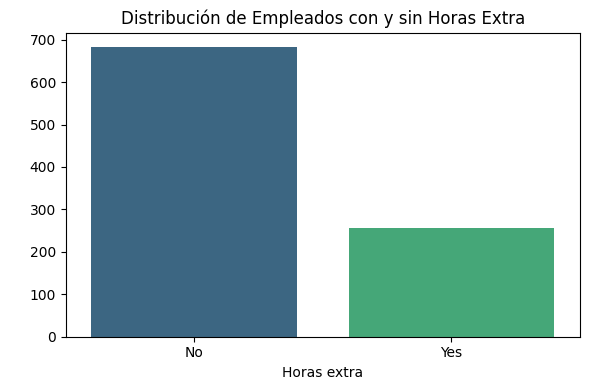

In [40]:
# Filtrar registros com valores válidos em 'overtime'
df_filtrado = df[df['overtime'] != 'Unknown']

# Gráfico: Distribución de empleados con y sin horas extra  SIN NULOS
plt.figure(figsize=(6, 4))
sns.countplot(data=df_filtrado, x='overtime', palette='viridis')
plt.title('Distribución de Empleados con y sin Horas Extra')
plt.xlabel('Horas extra')
plt.ylabel('  ')
plt.tight_layout()
plt.show()



/var/folders/fw/63lcqvrj3gj5_78zkmp2ql8r0000gp/T/ipykernel_20243/2857261039.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_no.index, y=total_no.values, ax=axes[0], palette='Blues')
/var/folders/fw/63lcqvrj3gj5_78zkmp2ql8r0000gp/T/ipykernel_20243/2857261039.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_yes.index, y=total_yes.values, ax=axes[1], palette='Blues')


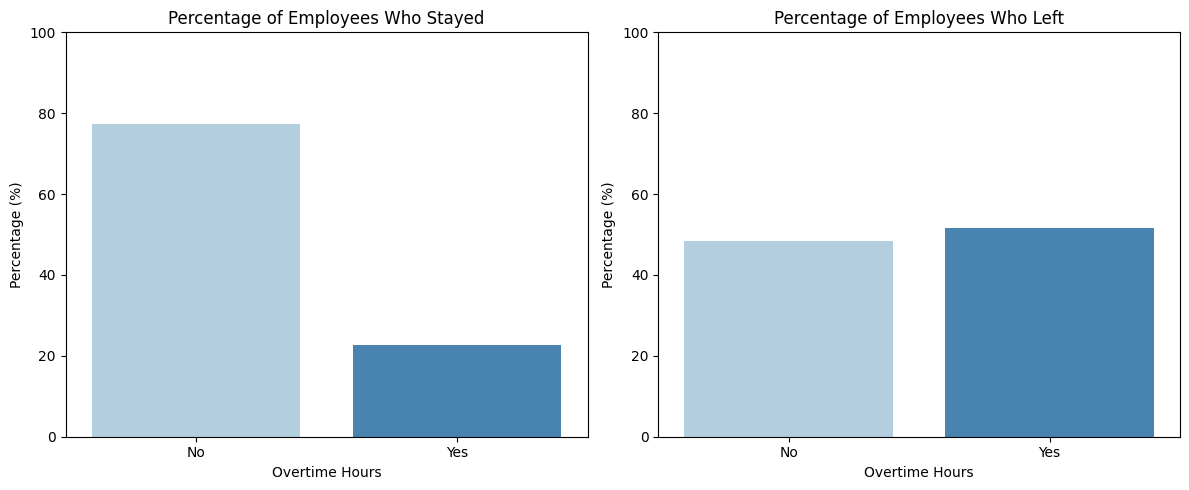

In [42]:
# Reordenar os valores para garantir que as cores sejam atribuídas corretamente
total_no = df_filtrado[df_filtrado['attrition'] == 'No']['overtime'].value_counts(normalize=True).reindex(['No', 'Yes']) * 100
total_yes = df_filtrado[df_filtrado['attrition'] == 'Yes']['overtime'].value_counts(normalize=True).reindex(['No', 'Yes']) * 100

# Criar gráficos com cores consistentes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3)
colors = ['skyblue', 'salmon']  # 'No' = azul, 'Yes' = salmão

# Gráfico: funcionários que permanecem
sns.barplot(x=total_no.index, y=total_no.values, ax=axes[0], palette='Blues')
axes[0].set_title('Percentage of Employees Who Stayed')
axes[0].set_xlabel('Overtime Hours')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_ylim(0, 100)

# Gráfico: funcionários que se marcharam
sns.barplot(x=total_yes.index, y=total_yes.values, ax=axes[1], palette='Blues')
axes[1].set_title('Percentage of Employees Who Left')
axes[1].set_xlabel('Overtime Hours')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()


| Tipo de gráfico     | Linha principal                         |
| ------------------- | --------------------------------------- |
| Quantidade absoluta | `sns.countplot(data=..., x='overtime')` |
| Proporção (%)       | `value_counts(normalize=True) * 100`    |


### Representatividad expreseiva de horas extras en los empleados que salieron 

⚠️

In [18]:
# Filtrar registros válidos (sem "Unknown" em overtime)
df_filtrado = df[df['overtime'] != 'Unknown']

# Agrupar por 'attrition' e calcular a % de 'overtime' = 'Yes'
porcentagem_overtime_por_attrition = (df_filtrado[df_filtrado['overtime'] == 'Yes'].groupby('attrition').size()/ df_filtrado.groupby('attrition').size()) * 100

# Exibir resultado arredondado
print(porcentagem_overtime_por_attrition.round(2))

attrition
No     22.62
Yes    51.66
dtype: float64


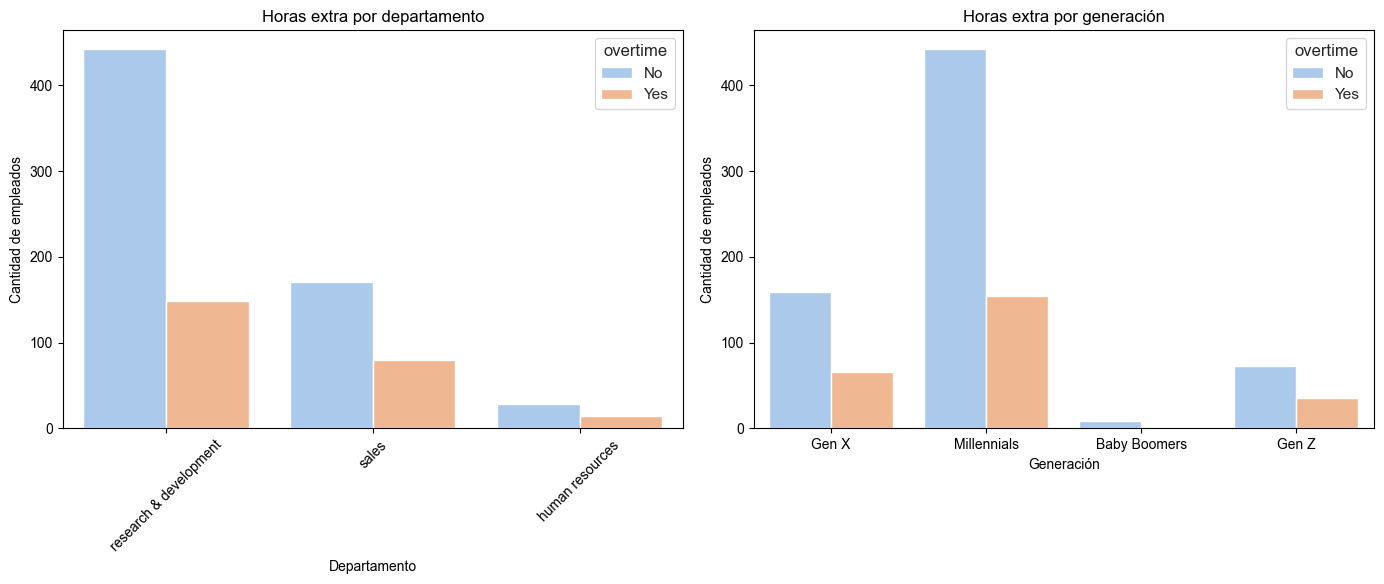

In [19]:

# Criar figura com 1 linha e 2 colunas
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plt.subplots_adjust(wspace=0.3)
sns.set(style="whitegrid")

# Gráfico 1: Horas extra por departamento
sns.countplot(data=df_filtrado, x='department', hue='overtime',
              ax=axes[0], palette='pastel')
axes[0].set_title('Horas extra por departamento')
axes[0].set_xlabel('Departamento')
axes[0].set_ylabel('Cantidad de empleados')
axes[0].tick_params(axis='x', rotation=45)

# Gráfico 2: Horas extra por generación
sns.countplot(data=df_filtrado, x='generation', hue='overtime',
              ax=axes[1], palette='pastel')
axes[1].set_title('Horas extra por generación')
axes[1].set_xlabel('Generación')
axes[1].set_ylabel('Cantidad de empleados')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


In [ ]:
# Filtrar apenas os funcionários que saíram e faziam horas extra
filtro = (df['attrition'] == 'Yes') & (df['overtime'] == 'Yes')
df_filtrados = df[filtro]

# Contar por departamento
departamentos = df_filtrados['jobrole'].value_counts()

# Mostrar resultado
print(departamentos)


jobrole
sales executive              19
research scientist           19
laboratory technician        17
sales representative         12
human resources               4
healthcare representative     2
manager                       2
manufacturing director        2
research director             1
Name: count, dtype: int64


In [ ]:
# Calcular proporção de funcionários com OverTime dentro de cada cargo
proporcao_overtime_por_role = (
    df[df['overtime'] == 'Yes'].groupby('jobrole').size() /
    df.groupby('jobrole').size()
) * 100

# Ordenar do maior para o menor
print(proporcao_overtime_por_role.sort_values(ascending=False).round(1))


jobrole
human resources              22.8
sales representative         22.2
research scientist           17.8
sales executive              15.7
healthcare representative    15.4
manager                      15.3
manufacturing director       13.9
research director            13.6
laboratory technician        12.6
dtype: float64


# Overtime por Departamiento

In [ ]:
# Filtrar empleados que hacen horas extra y NO han dejado la empresa
filtro = (df['overtime'] == 'Yes') & (df['attrition'] == 'No')
df_filtrados = df[filtro]

# Contar por departamento
departamentos = df_filtrados['department'].value_counts()

# Mostrar resultado
print(departamentos)


department
research & development    108
sales                      49
human resources            10
Name: count, dtype: int64


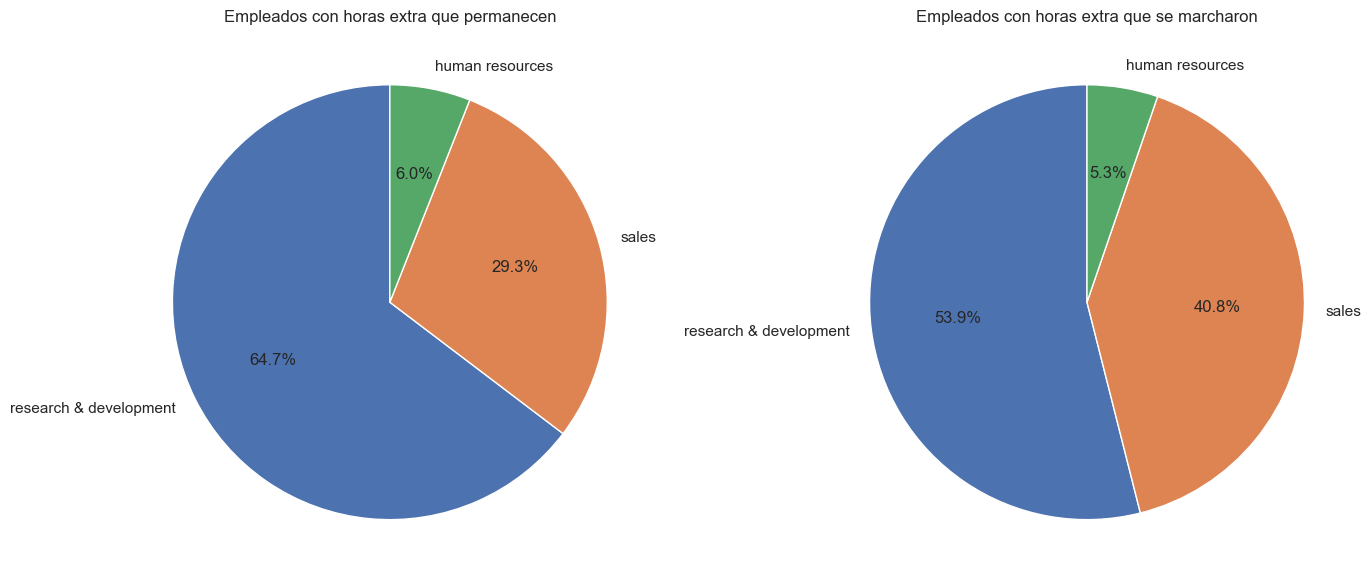

In [ ]:
# Filtrar empleados que hacen horas extra y permanecen
filtro_no = (df['overtime'] == 'Yes') & (df['attrition'] == 'No')
departamentos_no = df[filtro_no]['department'].value_counts(normalize=True) * 100

# Filtrar empleados que hacen horas extra y se marcharon
filtro_yes = (df['overtime'] == 'Yes') & (df['attrition'] == 'Yes')
departamentos_yes = df[filtro_yes]['department'].value_counts(normalize=True) * 100

# Crear los dos gráficos de tarta
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plt.subplots_adjust(wspace=0.3)

# 🥧 Gráfico 1: Permanecen
axes[0].pie(departamentos_no, labels=departamentos_no.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Empleados con horas extra que permanecen')

# 🥧 Gráfico 2: Se marcharon
axes[1].pie(departamentos_yes, labels=departamentos_yes.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Empleados con horas extra que se marcharon')

plt.tight_layout()
plt.show()


# Simulacion con Unknown de Overtime Rellenado

# Basado en el Job Role

In [ ]:
# Filtrar solo los registros con OverTime igual a 'Unknown'
df_unknown = df[df['overtime'] == 'Unknown']

# Contar cuántos empleados con 'Unknown' hay por departamento
departamentos_unknown = df_unknown['jobrole'].value_counts()

# Mostrar resultado
print(departamentos_unknown)

porcentajes_departamento_unknown = (departamentos_unknown / departamentos_unknown.sum()) * 100
print(porcentajes_departamento_unknown.round(2))


jobrole
sales executive              176
research scientist           126
laboratory technician        118
manufacturing director        69
healthcare representative     58
manager                       46
sales representative          36
research director             31
human resources               16
Name: count, dtype: int64
jobrole
sales executive              26.04
research scientist           18.64
laboratory technician        17.46
manufacturing director       10.21
healthcare representative     8.58
manager                       6.80
sales representative          5.33
research director             4.59
human resources               2.37
Name: count, dtype: float64


# Basado en el %

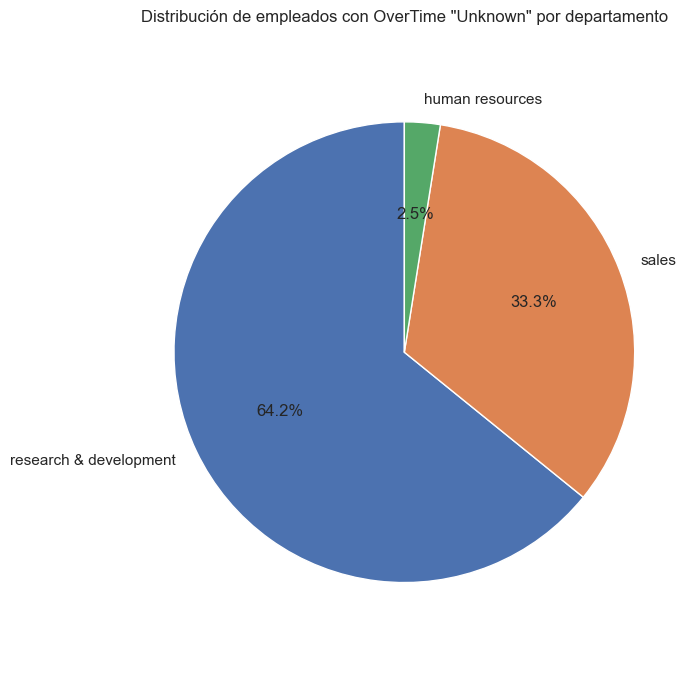

In [ ]:
# Filtrar empleados con OverTime = 'Unknown'
df_unknown = df[df['overtime'] == 'Unknown']

# Contar por departamento
departamentos_unknown = df_unknown['department'].value_counts()
porcentajes_departamento_unknown = (departamentos_unknown / departamentos_unknown.sum()) * 100

# Crear gráfico de tarta
plt.figure(figsize=(7, 7))
plt.pie(porcentajes_departamento_unknown,
        labels=porcentajes_departamento_unknown.index,
        autopct='%1.1f%%',
        startangle=90)
plt.title('Distribución de empleados con OverTime "Unknown" por departamento')
plt.axis('equal')  # Círculo perfecto
plt.tight_layout()
plt.show()


In [ ]:
# 1. Filtrar los datos válidos (sin 'Unknown')
df_validos = df[df['overtime'] != 'Unknown']

# 2. Calcular la proporción de 'Yes' y 'No'
proporciones = df_validos['overtime'].value_counts(normalize=True)

# 3. Contar cuántos empleados tienen 'Unknown'
n_unknown = (df['overtime'] == 'Unknown').sum()

# 4. Estimar cuántos de esos Unknown serían 'Yes' y cuántos 'No'
estimacion = proporciones * n_unknown

estimacion_percentual = (estimacion / n_unknown) * 100

# 5. Mostrar los resultados
print(' Proporciones en los datos conocidos:\n')
print(proporciones.round(2))

print(f'\nTotal de empleados con "Unknown": {n_unknown}')

print('\nEstimación de cómo se podrían repartir esos "Unknown":')
print(estimacion_percentual.round(0))


 Proporciones en los datos conocidos:

overtime
No     0.73
Yes    0.27
Name: proportion, dtype: float64

Total de empleados con "Unknown": 676

Estimación de cómo se podrían repartir esos "Unknown":
overtime
No     73.0
Yes    27.0
Name: proportion, dtype: float64


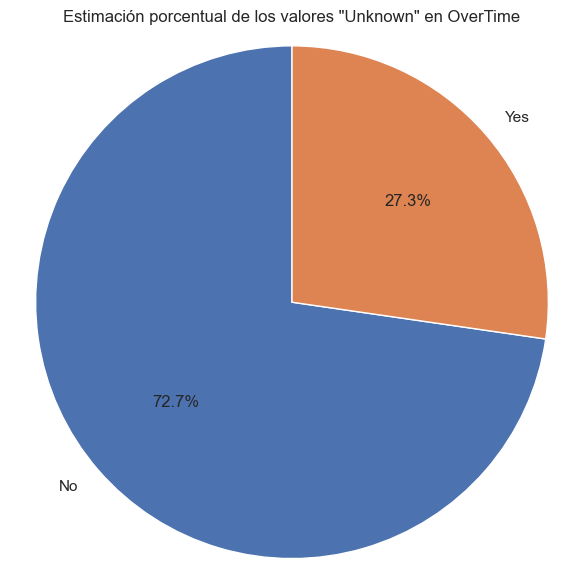

In [ ]:
# Gráfico de tarta da estimativa percentual
plt.figure(figsize=(6, 6))
plt.pie(estimacion_percentual,
        labels=estimacion_percentual.index,
        autopct='%1.1f%%',
        startangle=90)

plt.title('Estimación porcentual de los valores "Unknown" en OverTime')
plt.axis('equal')  # Para que sea un círculo perfecto
plt.tight_layout()
plt.show()


# Trabajo Remoto

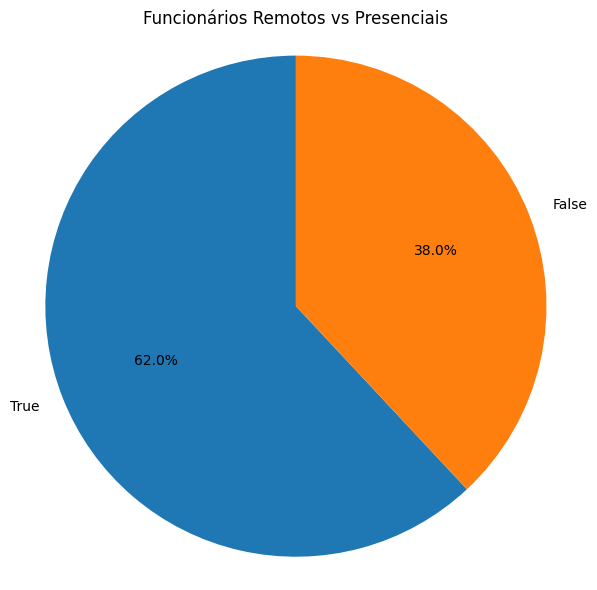

In [ ]:
# Contagem de trabalho remoto
remote_counts = df['remotework'].value_counts()

# Gráfico de pizza
plt.figure(figsize=(6, 6))
plt.pie(remote_counts, labels=remote_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Funcionários Remotos vs Presenciais')
plt.axis('equal')
plt.tight_layout()
plt.show()


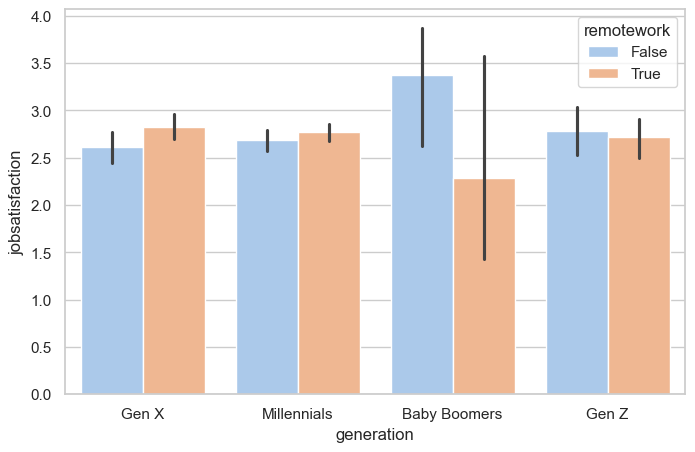

In [ ]:
# gen y trabajo remoto
# los baby boomers tiene mas satisfaccion cuando trabajan presencial?

plt.figure(figsize=(8,5))
sns.barplot(data=df,
    x='generation',
    y='jobsatisfaction', hue='remotework',
    palette='pastel');